# MC-Dropout Classification

## Imports

In [1]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger
from torch.optim import Adam

from lightning_uq_box.datamodules import TwoMoonsDataModule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import MCDropoutClassification
from lightning_uq_box.viz_utils import (
    plot_predictions_classification,
    plot_training_metrics,
    plot_two_moons_data,
)

plt.rcParams["figure.figsize"] = [14, 5]

INFO:root:Asdfghjkl backend not available since the old asdfghjkl dependency is not installed. If you want to use it, run: pip install git+https://git@github.com/wiseodd/asdl@asdfghjkl


In [2]:
seed_everything(0)

Seed set to 0


0

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

In [4]:
dm = TwoMoonsDataModule(batch_size=128)

X_train, Y_train, X_test, Y_test, test_grid_points = (
    dm.X_train,
    dm.Y_train,
    dm.X_test,
    dm.Y_test,
    dm.test_grid_points,
)

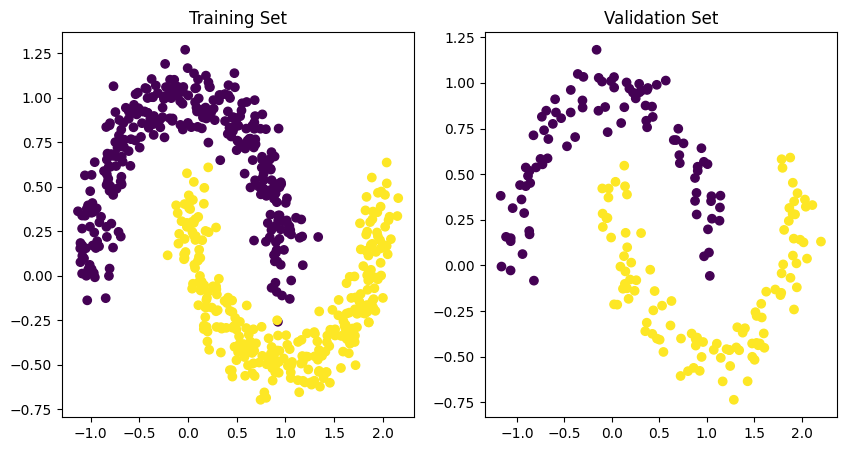

In [5]:
fig = plot_two_moons_data(X_train, Y_train, X_test, Y_test)

## Model

In [6]:
network = MLP(
    n_inputs=2,
    n_hidden=[50, 50, 50],
    n_outputs=2,
    dropout_p=0.2,
    activation_fn=nn.ReLU(),
)
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [7]:
mc_dropout_module = MCDropoutClassification(
    model=network,
    optimizer=partial(Adam, lr=1e-2),
    loss_fn=nn.CrossEntropyLoss(),
    num_mc_samples=25,
)

## Trainer

In [8]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
    default_root_dir=my_temp_dir,
)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(mc_dropout_module, dm)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | MLP              | 5.4 K  | train
1 | loss_fn       | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.021     Total estimated model params size (MB)
23        Mod

## Training Metrics

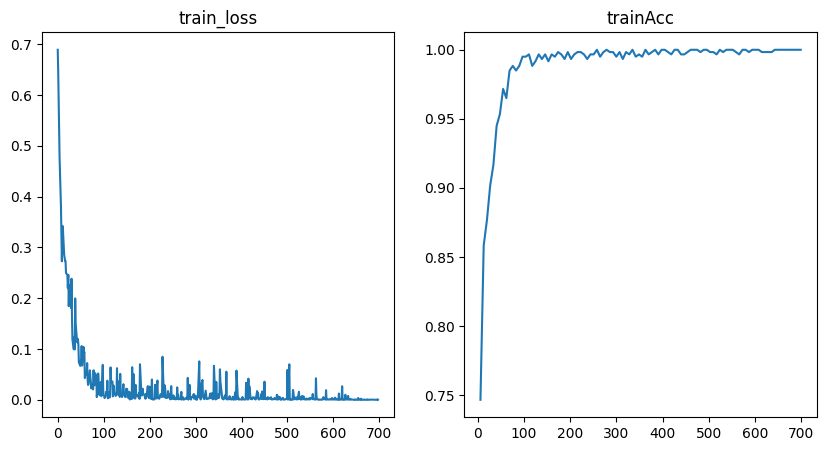

In [10]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainAcc"]
)

## Prediction

In [11]:
# save predictions
trainer.test(mc_dropout_module, dm.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          testAcc          │            1.0            │
│      testCalibration      │   0.0011549234623089433   │
│  testEmpirical Coverage   │            1.0            │
└───────────────────────────┴───────────────────────────┘

[{'testAcc': 1.0,
  'testCalibration': 0.0011549234623089433,
  'testEmpirical Coverage': 1.0}]

In [12]:
preds = mc_dropout_module.predict_step(test_grid_points)

## Evaluate Predictions

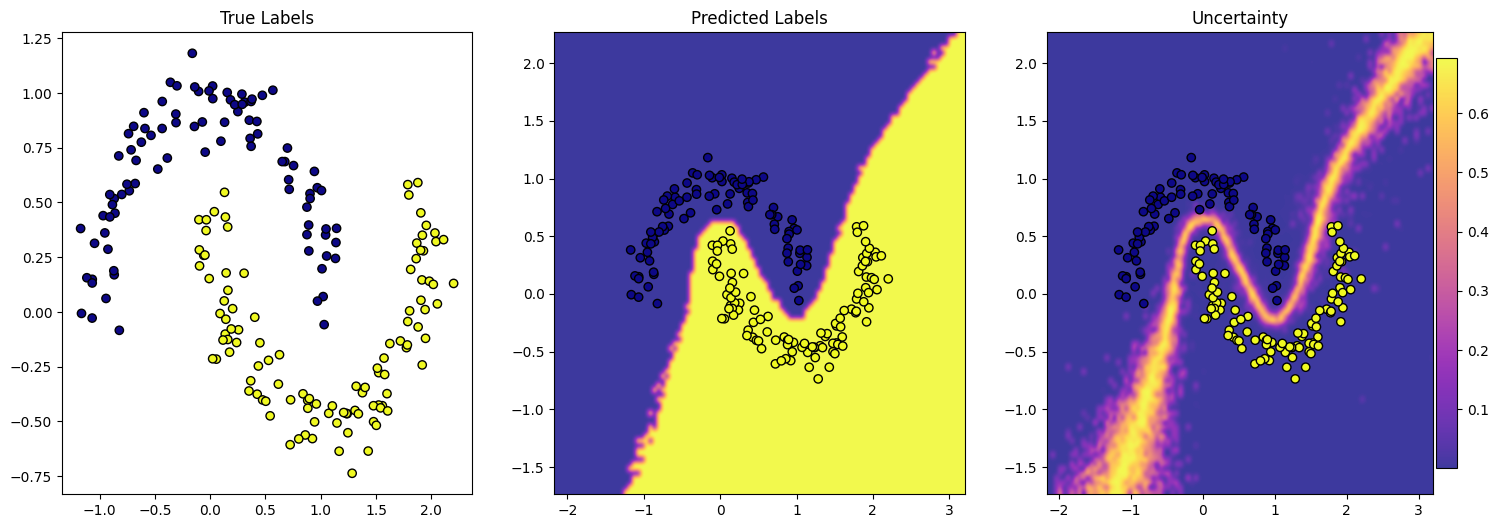

In [13]:
fig = plot_predictions_classification(
    X_test, Y_test, preds["pred"].argmax(-1), test_grid_points, preds["pred_uct"]
)